In [ ]:
# testing notebook for individual voxels in (x1:x2, y1:y2) along with a diffusion weighted image

In [1]:
# utils
import os
import sys
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
from tqdm import tqdm
import pickle

# data
import numpy as np
import scipy
import scipy.optimize as optimize
from scipy.io import loadmat
from scipy.signal import argrelextrema
import ants
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# dbsi
from dbsipy.dbsi.dbsi_utilities import *
from dbsipy.dbsi.dbsi_equations import *
from dbsipy.dbsi.dbsi_run import *
# ivim
from dipy.reconst.ivim import IvimModel
from dipy.core.gradients import gradient_table

/home/dan/.local/lib/python3.8/site-packages/dipy/reconst/ivim.py:159: UserWarning:

Bounds for this fit have been set from experiments and literature survey. To change the bounds, please input your bounds in model definition...

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]




primary_aniso_ff:  175.4898810527783
primary_axial_diffusivity:  0.001126975313517749
primary_radial_diffusivity:  0.00017623545723455757
primary_aniso:  [-7.10132846e-01  7.04067688e-01 -1.77787081e-04]
iso_ff:  [22.17447487 32.72990857 29.6111634   7.20807199  1.76464691  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.08682682  6.82816384  9.68604082 18.16969944
 33.082538   35.86043129]


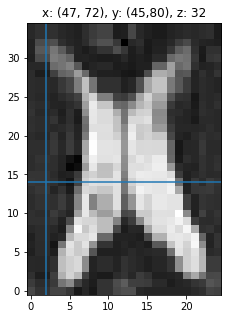

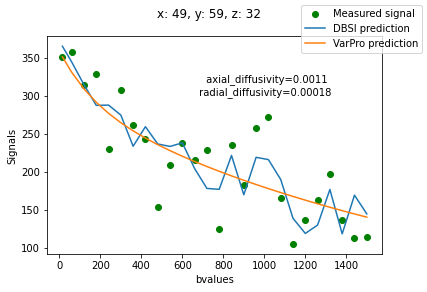

In [4]:
# load image, diffusion gradient directions, and b-values
dbsi_data, dbsi_mask = load_image('../dbsipy/data/dbsi_dataset.nii')
bvecs = np.loadtxt('../dbsi_bvec.txt')[:]
bvals = np.loadtxt('../dbsi_bval.txt')[:]
# basis tensors
dbasis = loadmat('../dbsipy/data/dbset_100.mat')
basis_tensors = dbasis['xx'][:95]

a1 = (49, 59) # correctly identified anisotrophy
a2 = (60, 50) # incorrectly identified anisotrophy
i1 = (56, 65) # correctly identified isotrophy
i2 = (63, 60) # incorrectly identified isotrophy
points = [a1, a2, i1, i2]
p = 0

i = points[p][0]
j = points[p][1]
k = 32
b = 1
s_k = dbsi_data[i, j, k, :]

# sorting
bvecs = bvecs[np.argsort(bvals)]
dbsi_data = dbsi_data[:, :, :, np.argsort(bvals)]
bvals = np.sort(bvals)
# taking only last 26 values
bvecs = bvecs[1:]
bvals = bvals[1:]
dbsi_data = dbsi_data[:, :, :, 1:]
s_k = dbsi_data[i, j, k, :]

s = 5
plt.figure(figsize=(s, s))
x1, x2 = 47, 72
y1, y2 = 45, 80
plt.title("x: ({}, {}), y: ({},{}), z: {}".format(x1, x2, y1, y2, k))
plt.imshow(dbsi_data[x1:x2, y1:y2, k, 1].T, origin='lower', cmap="gray")
plt.axhline(y=j-y1)
plt.axvline(x=i-x1)


# DBSI prediction
fa, primary_aniso_ff, primary_axial_diffusivity, primary_radial_diffusivity, restricted_ff, hindered_ff, free_water_ff, primary_aniso, iso_ff = fit_voxel_data(s_k, basis_tensors, bvecs, bvals)
s_k_predicted = dbsi_predict(bvecs, bvals, primary_aniso, primary_aniso_ff, iso_ff, [primary_radial_diffusivity, primary_axial_diffusivity])

# IVIM prediction
gtab = gradient_table(bvals, bvecs, b0_threshold=15)
ivimmodel_vp = IvimModel(gtab, fit_method='VarPro')
ivimfit_vp = ivimmodel_vp.fit(s_k[None, None])

# prediction plot against actual
fig, ax = plt.subplots(1)
ax.scatter(bvals, s_k, color="green", label="Measured signal")
ax.plot(bvals, s_k_predicted, label="DBSI prediction")
ivim_predict_vp = ivimfit_vp.predict(gtab)[0, 0, :]

ax.plot(gtab.bvals, ivim_predict_vp, label="VarPro prediction")
text_fit = """\n axial_diffusivity={:06.4f}\n radial_diffusivity={:06.5f} """.format(primary_axial_diffusivity, primary_radial_diffusivity)
ax.text(0.65, 0.80, text_fit, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
ax.set_xlabel("bvalues")
ax.set_ylabel("Signals")
fig.suptitle("x: {}, y: {}, z: {}".format(i, j, k))
fig.legend(loc='upper right')

# params
print("\n")
print("primary_aniso_ff: ", primary_aniso_ff)
print("primary_axial_diffusivity: ", primary_axial_diffusivity)
print("primary_radial_diffusivity: ", primary_radial_diffusivity)
print("primary_aniso: ", primary_aniso)
print("iso_ff: ", iso_ff)


Text(16.32, 15.3, 'i2')

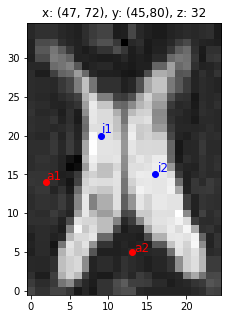

In [3]:
s = 5
plt.figure(figsize=(s, s))
x1, x2 = 47, 72
y1, y2 = 45, 80
plt.title("x: ({}, {}), y: ({},{}), z: {}".format(x1, x2, y1, y2, k))
plt.imshow(dbsi_data[x1:x2, y1:y2, k, 1].T, origin='lower', cmap="gray")

a1 = (49, 59) # correctly identified anisotrophy
a2 = (60, 50) # incorrectly identified anisotrophy
i1 = (56, 65) # correctly identified isotrophy
i2 = (63, 60) # incorrectly identified isotrophy

plt.scatter(a1[0]-x1, a1[1]-y1, color="red")
plt.text((a1[0]-x1) * (1 + 0.02), (a1[1]-y1) * (1 + 0.02) , "a1", fontsize=12, color="red")
plt.scatter(a2[0]-x1, a2[1]-y1, color="red")
plt.text((a2[0]-x1) * (1 + 0.02), (a2[1]-y1) * (1 + 0.02) , "a2", fontsize=12, color="red")
plt.scatter(i1[0]-x1, i1[1]-y1, color="blue")
plt.text((i1[0]-x1) * (1 + 0.02), (i1[1]-y1) * (1 + 0.02) , "i1", fontsize=12, color="blue")
plt.scatter(i2[0]-x1, i2[1]-y1, color="blue")
plt.text((i2[0]-x1) * (1 + 0.02), (i2[1]-y1) * (1 + 0.02) , "i2", fontsize=12, color="blue")

/tmp/ipykernel_350/1753197933.py:13: MatplotlibDeprecationWarning:

Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.



[0.58778525 0.80901699 0.        ]
0.002042599863190034
0.0


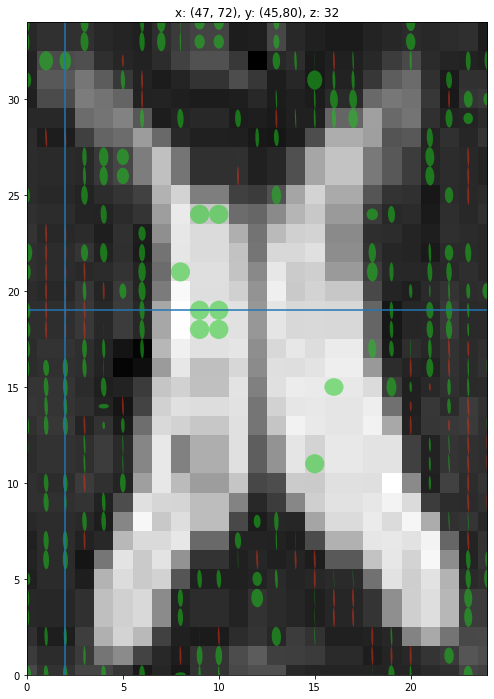

In [13]:
# diffusion weighted image
# currently defining ang to be between the x-axis and the anisotropy vector
# which could be wrong. This is because the angle spans across basis tensors and bvecs

xs = x2 - x1
ys = y2 - y1

# make a (xs, ys) grid of points
x = np.linspace(0, xs, xs)
y = np.linspace(0, ys, ys)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# define Ellipse class
class Ellipse(patches.Ellipse):
    def __init__(self, xy, width, height, angle, **kwargs):
        super().__init__(xy, width, height, angle, **kwargs)

    def draw(self, renderer):
        super().draw(renderer)

# make a (xs, ys) grid of ellipses
s = 1000
ellipses = []
colors = []
for i in range(xs):
    for j in range(ys):

        aniso = anisos[i,j]
        radial = radials[i,j]*s
        axial = axials[i,j]*s
        # nan
        if (np.isnan(aniso).sum() == 3):
            continue
        # isotropic
        if np.abs(np.sum(aniso)) == 0:
            continue
        # anisotropic
        else:

            if (axial > 1):
                axial = 1
            if(radial > 1):
                radial = 1


            if (radial == 0):
                radial = .1
                colors.append((.9, .2, 0.1))
            else:
                colors.append((.1, .8, 0.1))
        
            ang = np.apply_along_axis(angle_between, 0, aniso, np.array([1,0,0]))
            ellipses.append(Ellipse(xy=(i, j), width=radial, height=axial, angle=ang))

# plot the ellipses
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.set_xlim(0, xs - 1)
ax.set_ylim(0, ys - 1)

num_aniso_zeros = 0
for i in range(x2-x1):
    for j in range(y2-y1):
        if anisos[i,j].sum() == 0:
            num_aniso_zeros+=1
num_none = np.sum(np.isnan(axials))

for i in range((xs * ys) - 1 - (num_aniso_zeros + num_none)):
    ax.add_artist(ellipses[i])
    ellipses[i].set_clip_box(ax.bbox)
    ellipses[i].set_alpha(0.5)
    ellipses[i].set_facecolor(colors[i])

plt.imshow(dbsi_data[x1:x2, y1:y2, k, 1].T, origin='lower', cmap="gray")


print(anisos[i-x1,j-y1])
print(axials[i-x1,j-y1])
print(radials[i-x1,j-y1])
plt.title("x: ({}, {}), y: ({},{}), z: {}".format(x1, x2, y1, y2, k))
plt.axvline(x=i-x1)
plt.axhline(y=j-y1)

plt.show()

In [10]:
# try to fit voxels in (x1:x2, y1:y2) and save diffusivity values or load in

if False:

    x1, x2 = 47, 72
    y1, y2 = 45, 80

    anisos = np.zeros((x2-x1, y2-y1, 3))
    axials = np.zeros((x2-x1, y2-y1))
    radials = np.zeros((x2-x1, y2-y1))
    
    for j in tqdm(range(y1, y2, 1)):
        for i in range(x1, x2, 1):
            print((i, j))

            try:
                fa, primary_aniso_ff, primary_axial_diffusivity, primary_radial_diffusivity, restricted_ff, hindered_ff, free_water_ff, primary_aniso, iso_ff = fit_voxel_data(dbsi_data[i, j, k, :], basis_tensors, bvecs, bvals)

                anisos[i-x1, j-y1] = primary_aniso
                axials[i-x1, j-y1] =  primary_axial_diffusivity
                radials[i-x1, j-y1] = primary_radial_diffusivity
            except:
                print("error")
                anisos[i-x1, j-y1] = None
                axials[i-x1, j-y1] = None
                radials[i-x1, j-y1] = None

    params = (anisos, axials, radials)
    with open('aniso_params.pkl', 'wb') as f:
        pickle.dump(params, f)
else:
    with open('aniso_params.pkl', 'rb') as f:
        params = pickle.load(f)
        anisos = params[0]
        axials = params[1]
        radials = params[2]

/tmp/ipykernel_1608/165644458.py:13: MatplotlibDeprecationWarning:

Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.



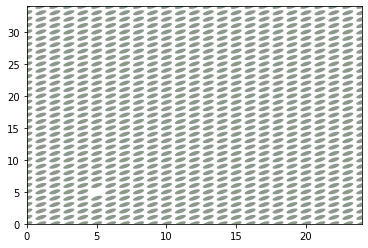

In [15]:
# give me a 10 x 10 plot where each point holds an ellipse.
# the ellipses should make a spiral around the center of the plot
# which would be at point (5,5)
# the ellipses should be centered at the center of each point
# the ellipses should be the same size
# the ellipses should be rotated by 45 degrees
# the ellipses should be filled with a color that is a function of the angle of the ellipse


xs = x2 - x1
ys = y2 - y1

# make a 10 x 10 grid of points
x = np.linspace(0, xs, xs)
y = np.linspace(0, ys, ys)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# define Ellipse class
class Ellipse(patches.Ellipse):
    def __init__(self, xy, width, height, angle, **kwargs):
        super().__init__(xy, width, height, angle, **kwargs)

    def draw(self, renderer):
        super().draw(renderer)


# make a 10 x 10 grid of ellipses
ellipses = []
for i in range(xs):
    for j in range(ys):
        if (i == 5) and (j == 5):
            continue
        ellipses.append(Ellipse(xy=(i, j), width=1, height=.5, angle=45))

# make a 10 x 10 grid of colors
colors = []
for i in range(xs):
    for j in range(ys):
        colors.append((.1, .2, 0.1))

# plot the ellipses
fig, ax = plt.subplots()
ax.set_xlim(0, xs - 1)
ax.set_ylim(0, ys - 1)
for i in range((xs * ys) - 1):
    ax.add_artist(ellipses[i])
    ellipses[i].set_clip_box(ax.bbox)
    ellipses[i].set_alpha(0.5)
    ellipses[i].set_facecolor(colors[i])

plt.show()